# CS4055 Project Group 7

# Notebook 2 - Predictive Modelling

__Note:__ This notebook may take 5-10 minutes to run 

===================================================================================================================

# 1 - Imports / Functions

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVR, LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFECV
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report

In [2]:
# import dataset
df = pd.read_csv('./studentPor.csv')

__Functions Used in Notebook:__

In [3]:
# for extracting the names of features that are selected during the feature selection process
def get_feature_names(feature_selector, dataframe, target):
    feature_names = dataframe.drop(target, axis=1).columns
    selected_features = feature_names[feature_selector.get_support()].tolist()
    return selected_features

# for plotting a confusion matrix as a heatmap
def plot_confusion_matrix_heatmap(true_values, pred_values):
    pred_values = pd.Series(pred_values)
    array = confusion_matrix(true_values, pred_values)
    df_cm = pd.DataFrame(array, index = [i for i in "ABCDEF"], columns = [i for i in "ABCDEF"])
    plt.figure(figsize = (5,4))
    ax = sns.heatmap(df_cm, annot=True, annot_kws={"size": 13}, cmap="Reds", fmt='g', cbar=False)
    ax.xaxis.tick_top()
    ax.xaxis.set_label_position('top')
    ax.tick_params(length=0)
    plt.yticks(rotation=0)
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)
    plt.xlabel('Predicted Values')
    plt.ylabel('True Values')

===================================================================================================================

# 2 - Remove Outliers

Refer to the EDA_FINAL_DOC Notebook for a detailed explanation of the removal of outliers.

In [4]:
Q1 = df['absences'].quantile(0.25)
Q3 = df['absences'].quantile(0.75)
IQR = Q3 - Q1

In [5]:
df['iqr'] = (df['absences'] < (Q1 - 1.5 * IQR)) | (df['absences'] > (Q3 + 1.5 * IQR))

# a new df with outliers removed
df_data = df[df.iqr != True]
df_data = df_data.drop('iqr', axis = 1)

# reset the dataframe index
df_data = df_data.reset_index(drop=True)

===================================================================================================================

# 3 - Convert Categorical Attributes to Numeric

In [6]:
df_dummies = pd.get_dummies(df_data, drop_first=True, columns=['school',
                                                               'sex',
                                                               'address',
                                                               'famsize',
                                                               'Pstatus',
                                                               'Mjob',
                                                               'Fjob',
                                                               'reason',
                                                               'guardian',
                                                               'schoolsup',
                                                               'famsup',
                                                               'paid',
                                                               'activities',
                                                               'nursery',
                                                               'higher',
                                                               'internet',
                                                               'romantic'])

Note that we have artificially increased the number of features from 33 to 41 in this step.

This is beacuse the get_dummies method adds extra features when converting categorical features to numeric.

__For example:__

If a feature has 3 categories (like __guardian__ - mother, father and other), then the method adds 2 extra features:
1. __guardian_mother__ - which will have a value of 0 or 1
2. __guradian_other__ - which will have a value of 0 or 1

Only one of these features can have a value of 1, and if both are 0 then it means that the guardian is the father by default. The method then deletes the original guardian column with the 2 mentioned here replacing it.

===================================================================================================================

# 4 - Reduce Target to Fewer Categories

Beacuse we have 20 categories to which our target feature may belong, it would be very difficult to train a predictive model to correctly predict 1 of these 20 categories.

Our initial instinct was to overcome this by reducing the target feature categories into binary values (pass/fail or 0/1).

We explored this and quickly realised this caused imbalance in the target feature.

In [7]:
# get the actual values for G3 and save to a numpy array
G3 = df_dummies["G3"].values
grade = []
# iterate through every G3 value and save the corresponding grade category to the grade array
for number in G3:
    if number >= 8:
        grade.append('pass') # pass
    else:
        grade.append('fail') # fail

# convert the grade array to a pandas dataframe
grade = pd.DataFrame(data=grade, columns=["grade"])
grade['grade'].value_counts()

pass    599
fail     29
Name: grade, dtype: int64

It can be seen that there are far more passes than fails. This imbalance may skew our predictive models and result in a poor performance.

We then decided a better approach would be to use the traditional 6 grade categories of A-F.

This will give us a better chance of predicting the target as we have only 6 categories instead of 20.

This also provides a relatively more balanced target.

In [8]:
grade = []
# iterate through every G3 value and save the corresponding grade category to the grade array
for number in G3:
    if number >= 17:
        grade.append('0') # grade = A
    elif number >= 15:
        grade.append('1') # grade = B
    elif number >= 13:
        grade.append('2') # grade = C
    elif number >= 11:
        grade.append('3') # grade = D
    elif number >= 8:
        grade.append('4') # grade = E
    else:
        grade.append('5') # grade = F

# convert the grade array to a pandas dataframe
grade = pd.DataFrame(data=grade, columns=["grade"])
# create a new dataframe called data by joining grade with df_dummies
data = pd.concat([df_dummies, grade], axis=1)
# remove the original numeric G3 column because it is not needed
data.drop(columns="G3", axis=1, inplace=True)
grade['grade'].value_counts()

3    172
4    156
2    141
1     84
0     46
5     29
Name: grade, dtype: int64

===================================================================================================================

# 5 - Declare Predictors and Target

We identify our target feature and our predictor features for our predictive models.

In [9]:
# target attribute
target_attribute_name = "grade"
target = data[target_attribute_name]

# predictor attributes
predictors = data.drop(target_attribute_name, axis = 1).values

===================================================================================================================

# 6 - Split Dataset into Training and Test

Before building a predictive model, we first want to split the entire dataset up into a training dataset and a test dataset.

We will use the training dataset to build multiple predictive models. We then pick the best performing model and fit this to our test dataset in order to get the overall final accuracy of the model.

The ratio of training to test data is usually varied from 60-80% training data and 20-40% test data. For a smaller dataset it is recommened to use 80% for training and 20% for testing. This is the ratio we will use.

In order to maintain the same ratio of target categories in both datasets, it is neccessary to stratify the dataset.

We also assign the random_state a constant value (seed). This is to ensure an identical split each time the program runs. This seed value is also assigned to random_state in some of our algorithms in section 8.

In [10]:
# assign a constant value to be used for random_state (otherwise a random number is chosen)
seed = 9

In [11]:
# prepare independent stratified data sets for training and testing of the models
predictors_train, predictors_test, target_train, target_test = train_test_split(predictors, 
                                                                                target, 
                                                                                test_size=0.20, 
                                                                                shuffle=True, 
                                                                                stratify=target,
                                                                                random_state=seed)

===================================================================================================================

# 7 - Feature Selection

We will use the same two feature selection methods (estimators) that were used in lab 5. These include __SVR__ (Support Vector Regression) and __LR__ (Logistic Regression).

Each estimator will be fitted to the training dataset in order to predict the target. This will happen in conjuction with __Recursive Feature Elimantion (RFE)__. RFE will run recursively, each time picking different subsets of features to train. The poorest performing features will be eliminated and the best subset of features will be returned at the end.

__K-fold Cross Validation__ is also incorporated in the training process. We have chosen to use __5 folds__ here as the dataset is relatively small.

This feature selection process is performed only once. The selected features in section 7 are then passed into each algorithm in section 8. There is no need to perform this step again for each algorithm as the resulting selected features will be the same each time.

### a) Using Support Vector Regression (SVR)

In [12]:
# create a base classifier used to evaluate a subset of attributes
estimatorSVR = SVR(kernel="linear")
# create the RFE model that incorporates k-fold cross validation where k = 5
selectorSVR = RFECV(estimatorSVR, cv=5)
# use the model on the training data to select the best features for prediction
selectorSVR = selectorSVR.fit(predictors_train, target_train)
# transform the training data to only include the selected features
predictors_train_SVRselected = selectorSVR.transform(predictors_train)
# transform the test data to only include the selected features
predictors_test_SVRselected = selectorSVR.transform(predictors_test)
# print out the features that were selected
get_feature_names(selectorSVR, data, target_attribute_name)

['failures',
 'G1',
 'G2',
 'Mjob_health',
 'Fjob_health',
 'Fjob_other',
 'Fjob_services',
 'reason_other',
 'schoolsup_yes',
 'famsup_yes',
 'higher_yes']

SVR has chosen the above subset of 11 features as the best selection to train a predictive model. This is a lot less than the total number of features which is 41 (as explained in section 3).

### b) Using Logistic Regression (LR)

In [13]:
# create a base classifier used to evaluate a subset of attributes
estimatorLR = LogisticRegression(solver='lbfgs', multi_class='auto', max_iter=6500)
# create the RFE model that incorporates k-fold cross validation where k = 5
selectorLR = RFECV(estimatorLR, cv=5)
# use the model on the training data to select the best features for prediction
selectorLR = selectorLR.fit(predictors_train, target_train)
# transform the training data to only include the selected features
predictors_train_LRselected = selectorLR.transform(predictors_train)
# transform the test data to only include the selected features
predictors_test_LRselected = selectorLR.transform(predictors_test)
# print out the features that were selected
get_feature_names(selectorLR, data, target_attribute_name)

['age',
 'traveltime',
 'studytime',
 'failures',
 'G1',
 'G2',
 'school_MS',
 'reason_home',
 'reason_other',
 'higher_yes']

LR has chosen the above subset of 10 features as the best selection to train a predictive model.

It is interesting to note the similarities between these features and the SVR selected features.

- G1, G2, failures, reason_other and higher_yes are common to both.

G1 and G2 will always be chosen as important features as these obviously have a high correlation with the target (G3)

===================================================================================================================

# 8 - Compare Classifiers

We can use the cheat sheet from SK Learn, see below (note that this may not be visible if viewing in html, in which case the image can be found in the predictor_model folder), to help us pick a suitable algorithm for training a predictive model.

Following the path that best describes our dataset, there are 4 algorithms suggested for us to try:

- Linear SVC (section 8.1)
- k-Nearest Neighbors (section 8.2)
- SVC (section 8.3)
- Ensemble Classifiers (Random Forest) (section 8.4)

<img src="ml_map.png">

For each algorithm we will use __3 pipelines__ (one using features selected by SVR, one using features selected by LR and one using all features).

The method we will use to train all our models is __Grid Search Cross Validation (GridSearchCV)__.

One advantage of using GridSearchCV over cross_val_score, for example, is that it allows us to pass in a selection of hyper-parameters to the model.

It will train a model using each available hyper-parameter and choose the best performing one.

Examples of hyper-parameters used to tune our models include:
- Penalty parameter of the error (__C__)
- k-value for k-Nearest Neighbor (__n_neighbors__)
- number of trees in Random Forest (__n_estimators__)
- maximum depth of each Random Forest tree (__max_depth__)

__Problem__: Because we are training 3 models (for each example of feature selection) for each of the 4 classifier algorithms (and using cross validation with 5 folds for each one), if we also pass in multiple different hyper-parameters for every single model we will end up with a large amount of computation required. The notebook would take a very long time to run all these models.

__Solution__: So in order to reduce the work that this notebook will have to do, we decided to experiment with the hyper-parameters in seperate individual roughwork notebooks for each algorithm. We could then pick the best performing parameters and use them in this notebook (the best_params_ method for GridSearchCV allows us to do this).

We ran each algorithm 5 times and picked the most frequent parameter values chosen. The results of our experimentation are as follows:

- __C:__ Values Tested (0.01, 0.1, 1, 10, 100, 1000, 10000). __1000__ was chosen most frequently.

- __n_neighbors:__ Values Tested (3, 5, 7, 9, 11). __7__ was chosen most frequently.

- __n_estimators:__ Values Tested (100, 150, 200, 250, 300). __250__ was chosen most frequently.

- __max_depth:__ Values Tested (2, 3, 4, 5). __4__ was chosen most frequently.

These are the values that we will use for our 4 algorithms.

-------------------------------------------------------------------------------------------------------------------

## 8.1 Linear SVC

#### a) Create classifer

Support Vector Classifer (SVC) is type of Support Vector Machine (SVM) learning algorithm.

Linear SVC is similar to SVC, but with the kernel parameter set to 'linear'.

Linear SVC is generally not suited for a small dataset size. This is why we get the convergence warnings when we run it below. We tried increasing the maximum iterations as the warning suggest, but no matter how large a value we tried it did not solve the convergence warning.

In [14]:
# note how we set the random_state to the constant seed value
classifier = LinearSVC(random_state=seed)

#### b) Set up pipeline

We pass in a scaler and the classifier. 

We could also incorporate feature selection in the pipeline itself, but we instead choose to only perform the feature selection once (in section 7) rather than repeating it for every pipeline. If we did incorporate it in the pipeline, the resulting features that would be selected would be identical everytime. Therefore this would be unneccessary and would require a lot of computation.

In [15]:
pipe = Pipeline([('scaler', MinMaxScaler()), ('classifier', classifier)])

#### c) Train models

We will have 3 models for each algorithm:
1. Using features selected by SVR
2. Using features selected by LR
3. Using all the features

Note how we pass in a C value of 1000 as a hyper-parameter here.

In [16]:
# create a list of differant parameters that will be passed into the classifier in each pipeline
params = {'classifier__C': [1000]}

# train final models using the pipeline and params (grid search with cross-validation is used)
modelSVR = GridSearchCV(pipe, params, cv=5, verbose=1, iid=False).fit(predictors_train_SVRselected, target_train)
modelLR = GridSearchCV(pipe, params, cv=5, verbose=1, iid=False).fit(predictors_train_LRselected, target_train)
modelAll = GridSearchCV(pipe, params, cv=5, verbose=1, iid=False).fit(predictors_train, target_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/endamccarthy/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/endamccarthy/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/endamccarthy/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/endamccarthy/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/endamccarthy/opt/ana

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Users/endamccarthy/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/endamccarthy/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/endamccarthy/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.3s finished
/Users/endamccarthy/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
[Parallel(n_jobs=1)]: Using backend Se

Fitting 5 folds for each of 1 candidates, totalling 5 fits


/Users/endamccarthy/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/endamccarthy/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/endamccarthy/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/endamccarthy/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:929: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.6s finished
/Users/endamccarthy/opt/anaconda3/lib/

(Note: The warnings here relate to the fact that the model failed to converge, this is because Linear SVC does not work well with such a small dataset)

#### d) Compare accuracies

In [17]:
accuracy_SVR = modelSVR.best_score_
accuracy_LR = modelLR.best_score_
accuracy_All = modelAll.best_score_

scores = {'Classifier':['Linear SVC'],
          'SVR Features':[accuracy_SVR],
          'LR Features':[accuracy_LR],
          'All Features':[accuracy_All]}

# create dataframe to store all the accuracies
accuracies_df = pd.DataFrame(scores)
accuracies_df.round(2)

,Classifier,SVR Features,LR Features,All Features
0,Linear SVC,0.37,0.42,0.35


-------------------------------------------------------------------------------------------------------------------

## 8.2 kNN

#### a) Create classifer

In kNN, k is the number of nearest neighbors. The number of neighbors is the core deciding factor. 

It is a type of supervised ML algorithm which can be used for both classification as well as regression. However, it is mainly used for classification predictive problems in industry. The following two properties are associated with kNN:

- Lazy learning. kNN is a lazy learning algorithm because it does not have a specialized training phase and uses all the data for training.

- Non-parametric learning. kNN is also a non-parametric learning algorithm because it doesn’t assume anything about the underlying data.

In [18]:
classifier = KNeighborsClassifier()

#### b) Set up pipeline

In [19]:
pipe = Pipeline([('scaler', MinMaxScaler()), ('classifier', classifier)])

#### c) Train models

Note how we pass in a n_neighbors value of 7 as a hyper-parameter here.

In [20]:
params = {'classifier__n_neighbors': [7]}

# train final models using the pipeline and params (grid search with cross-validation is used)
modelSVR = GridSearchCV(pipe, params, cv=5, verbose=1, iid=False).fit(predictors_train_SVRselected, target_train)
modelLR = GridSearchCV(pipe, params, cv=5, verbose=1, iid=False).fit(predictors_train_LRselected, target_train)
modelAll = GridSearchCV(pipe, params, cv=5, verbose=1, iid=False).fit(predictors_train, target_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.0s finished


#### d) Compare accuracies

In [21]:
accuracy_SVR = modelSVR.best_score_
accuracy_LR = modelLR.best_score_
accuracy_All = modelAll.best_score_

# add accuracies to dataframe
accuracies_df.loc[1] = ['kNN', accuracy_SVR, accuracy_LR, accuracy_All]
accuracies_df.round(2)

,Classifier,SVR Features,LR Features,All Features
0,Linear SVC,0.37,0.42,0.35
1,kNN,0.57,0.51,0.30


-------------------------------------------------------------------------------------------------------------------

## 8.3 SVC

#### a) Create classifer

Support Vector Classifier (SVC), as the name suggests, is similar to Linear SVC. However, it is a more accurate algorithm than Linear SVC.

SVC is better suited to a small dataset than Linear SVC. This is why we do not get any convergance warnings when we run this model.

In [22]:
# note how we set the random_state to the constant seed value
classifier = svm.SVC(gamma='scale', random_state=seed)

#### b) Set up pipeline

In [23]:
pipe = Pipeline([('scaler', MinMaxScaler()), ('classifier', classifier)])

#### c) Train models

Note how we pass in a C value of 1000 as a hyper-parameter here.

In [24]:
params = {'classifier__C': [1000]}

# train final models using the pipeline and params (grid search with cross-validation is used)
modelSVR = GridSearchCV(pipe, params, cv=5, verbose=1, iid=False).fit(predictors_train_SVRselected, target_train)
modelLR = GridSearchCV(pipe, params, cv=5, verbose=1, iid=False).fit(predictors_train_LRselected, target_train)
modelAll = GridSearchCV(pipe, params, cv=5, verbose=1, iid=False).fit(predictors_train, target_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    0.2s finished


#### d) Compare accuracies

In [25]:
accuracy_SVR = modelSVR.best_score_
accuracy_LR = modelLR.best_score_
accuracy_All = modelAll.best_score_

# add accuracies to dataframe
accuracies_df.loc[2] = ['SVC', accuracy_SVR, accuracy_LR, accuracy_All]
accuracies_df.round(2)

,Classifier,SVR Features,LR Features,All Features
0,Linear SVC,0.37,0.42,0.35
1,kNN,0.57,0.51,0.30
2,SVC,0.67,0.62,0.46


-------------------------------------------------------------------------------------------------------------------

## 8.4 Ensemble Classifiers (Random Forest)

#### a) Create classifer

There are two main types of Ensemble Classifiers:
1. Random Forest
2. Bagging

We have chosen Random Forest for our dataset as we are more familier with algorithm from experimentation in our labs.

Random Forest is a learning method that operates by constructing multiple decision trees. The final decision is made based on the majority of the trees and is chosen by the Random Forest.

In [26]:
# note how we set the random_state to the constant seed value
classifier = RandomForestClassifier(random_state=seed)

#### b) Set up pipeline

In [27]:
pipe = Pipeline([('scaler', MinMaxScaler()), ('classifier', classifier)])

#### c) Train models

Note how we pass in an n_estimators value of 250 and a max_depth value of 4 as hyper-parameters here.

In [28]:
params = {'classifier__n_estimators': [250],
          'classifier__max_depth': [4]}

# train final models using the pipeline and params (grid search with cross-validation is used)
modelSVR = GridSearchCV(pipe, params, cv=5, verbose=1, iid=False).fit(predictors_train_SVRselected, target_train)
modelLR = GridSearchCV(pipe, params, cv=5, verbose=1, iid=False).fit(predictors_train_LRselected, target_train)
modelAll = GridSearchCV(pipe, params, cv=5, verbose=1, iid=False).fit(predictors_train, target_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.8s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.9s finished


Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.8s finished


#### d) Compare accuracies

In [29]:
accuracy_SVR = modelSVR.best_score_
accuracy_LR = modelLR.best_score_
accuracy_All = modelAll.best_score_

# add accuracies to dataframe
accuracies_df.loc[3] = ['Ensemble (RF)', accuracy_SVR, accuracy_LR, accuracy_All]
accuracies_df.round(2)

,Classifier,SVR Features,LR Features,All Features
0,Linear SVC,0.37,0.42,0.35
1,kNN,0.57,0.51,0.30
2,SVC,0.67,0.62,0.46
3,Ensemble (RF),0.71,0.72,0.65


__Observations__

- There is relatively little difference between using the features selected by SVR or by LR.
- Using all the features has consistently poor results compared with selected features.
- The results reflect the SK Learn Algorithm Cheat-Sheet.
- A __Random Forest__ classifier with __features selected by Logistic Regression__ has the best performance.

===================================================================================================================

# 9 - Final Predictive Model

The above results prove that a __Random Forest classifier__ with __features selected by Logistic Regression__ is the best performing model.

We can now get a final accuracy using this model on the __test data__.

We will setup the model again just to ensure we have the correct variables selected.

In [30]:
classifier = RandomForestClassifier(random_state=seed)
pipe = Pipeline([('scaler', MinMaxScaler()), ('classifier', classifier)])
params = {'classifier__n_estimators': [250],
          'classifier__max_depth': [4]}
modelFinal = GridSearchCV(pipe, params, cv=5, verbose=1, iid=False).fit(predictors_train_LRselected, target_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:    1.8s finished


Now we can get the final accuracy using the test data:

In [31]:
accuracy_Final = modelFinal.score(predictors_test_LRselected, target_test)
print("The accuracy of our final predictive model is: %2d%%" %(accuracy_Final.round(2)*100))

The accuracy of our final predictive model is: 72%


In [32]:
target_test.value_counts()

3    35
4    31
2    28
1    17
0     9
5     6
Name: grade, dtype: int64

===================================================================================================================

# 10 - Evaluation of Final Model

### Confusion Matrix

This confusion matrix is based on the test dataset (20% of overall data, 126 rows).

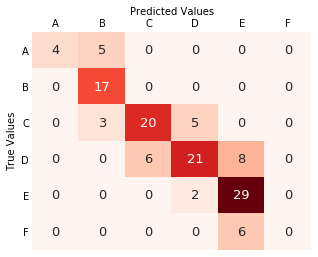

In [33]:
plot_confusion_matrix_heatmap(target_test, modelFinal.best_estimator_.predict(predictors_test_LRselected))

We can see from the confusion matrix that the results are relatively good by the high values on the diagonal.
- It is interesting to note that the model did not make any predictions for grade 'F'. It instead wrongly predicted the 6 true 'F' grades as 'E' grades.
- It predicted more 'A' grades wrong (5 as 'B') than right (4 as 'A').
- All 17 true 'B' grades were predicted correctly.
- The majority of 'C' grades were predicted correctly (20 out of 28).
- The majority of 'D' grades were predicted correctly (21 out of 35).
- The majority of 'E' grades were predicted correctly (29 out of 31).

### Precision-Recall

In [34]:
print(classification_report(target_test, modelFinal.best_estimator_.predict(predictors_test_LRselected)))

              precision    recall  f1-score   support

           0       1.00      0.44      0.62         9
           1       0.68      1.00      0.81        17
           2       0.77      0.71      0.74        28
           3       0.75      0.60      0.67        35
           4       0.67      0.94      0.78        31
           5       0.00      0.00      0.00         6

    accuracy                           0.72       126
   macro avg       0.65      0.62      0.60       126
weighted avg       0.71      0.72      0.70       126



/Users/endamccarthy/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


(Note: The warning here is present because the was no prediction for an 'F' grade.)

We can see how the Precision-Recall report backs up the Confusion Matrix:

The __precision__ of an 'A' grade (0) prediction is 100%. This means that every time the model predicted a grade of 'A', it was correct. This can be seen in the Confusion Matrix where there are 4 predicted 'A' grades which are all correct.

The __precision__ of a 'B' grade (1) prediction is 68%. This means that every time the model predicted a grade of 'B', it was correct only 68% of the time. This is supported by the Confusion Matrix where only 17 out of 25 (68%) predicted 'B' grades were correct.

The __recall__ of an 'A' grade (0) prediction is 44%. This means that out of all the true 'A' grades, only 44% were predicted correctly. This is supported by the Confusion Matrix where only 4 out of 9 (44%) true 'A' grades were predicted correctly.

The __recall__ of a 'B' grade (1) prediction is 100%. This means that out of all the true 'B' grades, 100% were predicted correctly. This is supported by the Confusion Matrix where 17 out of 17 (100%) true 'B' grades were predicted correctly.

The __overall accuracy__ is 72% which we already highlighted in section 9.

The __f1-score__ is given by the harmonic mean of precision and recall, it combines precision and recall of a class in one metric:
    
    (2 × precision × recall / (precision + recall)) 
    
===================================================================================================================

# 11 - Conclusion



Having followed all the steps from the labs 2-5, we have successfully practiced EDA, data preparation, train/test splits, feature selection, comparison of predictive models and evaluation of the best performing model throughout this notebook and the EDA notebook. We will demonstrate lab 6 (clustering) in another seperate notebook.

These are some of the observations and learning outcomes we made along the way:

- It was beneficial to reduce the target from 20 values (1-20) into 6 (A-F) categories. It is obviously easier to predict a value from 6 options rather than from 20 options. Our accuracy (72%) is still not quite high enough for this model to be considered a success. It would be interesting to reduce the categories again to 5 or 4 options. This would certainly improve the overall accuracy.

- Even after reducing the target into 6 categories there was still a certain amount of imbalance present (much more 'C', 'D' and 'E' grades than 'A' and 'F') which may have affected our model results. An interesting experiment to try when imbalance is present is to perform resampling on the dataset. However, this can have a negative impact if not fully understood and implemented correctly. 

- We used a train/test split of 20% which is generally recommended. If we had chosen a larger test split (say 30%), we may have ended up with greater variance in our predictions, but lower bias. There is a trade off between these, so 20% is generally recommended as a good balance.

- It is interesting to note how much longer it took to perform feature selection using Logistic Regression than SVR (roughly 10 times as long). We researched this but could not find any conclusive explanations.

Finally, we conclude that for the dataset used for this project, the Logistic Regression resulted as the best feature selector and Random Forest as the best classifier in our prediction model for G3.

-------------------------------------------------------------------------------------------------------------------
__Links__
- [SK Learn Cheat-Sheet](https://scikit-learn.org/stable/tutorial/machine_learning_map/index.html)
- [Linear SVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.LinearSVC.html#sklearn.svm.LinearSVC)
- [k-Nearest Neighbors](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html#sklearn.neighbors.KNeighborsClassifier)
- [SVC](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html#sklearn.svm.SVC)
- [Ensemble](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)
- [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)

===================================================================================================================